## Neural networks for segmentation

This is an __alternative assignment__ meaning that you can do it __instead of the main one__!

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import imageio
import cv2
import albumentations as A
import segmentation_models_pytorch as smp

In [2]:
import os
import pandas as pd
import re
import warnings
from tqdm.notebook import tqdm
import time
warnings.filterwarnings('ignore')

In [3]:
from torchvision import transforms as T
import torchvision

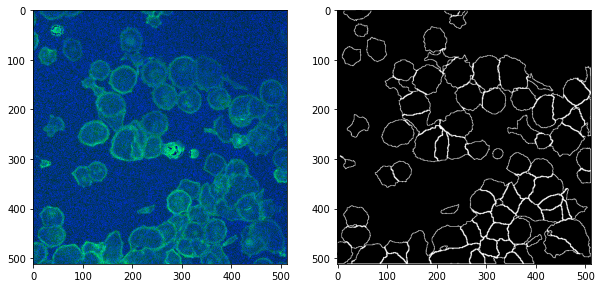

In [4]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = imageio.imread('data/BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imageio.imread('data/BBBC018_v1_outlines/train/00736-cells.png')
plt.imshow(mask, 'gray')

In [5]:
image_path_train = '/data/BBBC018_v1_images-fixed/train/'
mask_path_train = '/data/BBBC018_v1_outlines/train/'
image_path_val = '/data/BBBC018_v1_images-fixed/val/'
mask_path_val = '/data/BBBC018_v1_outlines/val/'
image_path_test = '/data/BBBC018_v1_images-fixed/test/'
mask_path_test = '/data/BBBC018_v1_outlines/test/' # создал для даталоадера можно заменить на next(iter(..))

In [6]:
def create_df(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_image_train = create_df(image_path_train)
df_mask_train = create_df(mask_path_train)
df_image_val = create_df(image_path_val)
df_mask_val = create_df(mask_path_val)
df_image_test = create_df(image_path_test)
df_mask_test = create_df(mask_path_test)

print('Total Images: ', len(df_image_train))

Total Images:  41


In [7]:
def apply_cell(df_image, df_mask):
    
    df_image['cell'] = np.nan
    for index, row in df_image.iterrows():
        df_image['cell'].loc[index] = re.search('.*-', row['id']).group(0)

    
    df_mask['cell'] = np.nan
    for index, row in df_mask.iterrows():
        df_mask['cell'].loc[index] = re.search('.*-', row['id']).group(0)
        
    return df_image.merge(df_mask, how = 'inner', on = 'cell', suffixes=('_image', '_mask')).drop(columns = 'cell')

In [8]:
df_train = apply_cell(df_image_train, df_mask_train)
df_val = apply_cell(df_image_val, df_mask_val)
df_test = apply_cell(df_image_test, df_mask_test)

Image Size (512, 512, 3)
Mask Size (512, 512)


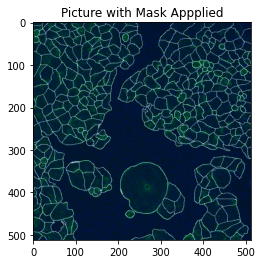

In [9]:
img = Image.open(image_path_train + df_train['id_image'][1] + '.DIB.bmp')
mask = Image.open(mask_path_train + df_train['id_mask'][1] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [122]:
class CellDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform = None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X['id_image'][idx] + '.DIB.bmp')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X['id_mask'][idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        aug = self.transform(image = img, mask = mask)
        img = Image.fromarray(aug['image'])
        mask = aug['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).view(1,256,256).long() # (512,512) -> (1,256,256)
        
        return img, mask

In [ ]:
# по поводу размера фоток решил понизить в два раза, до этого повышал в два - плюс минус то же самое

In [123]:
mean=[0.485, 0.456, 0.406] # взял как в туториале торча не особо понятно как оптимально подгонять их под датасеты
std=[0.229, 0.224, 0.225]

# в качестве аугментации тоже легкий затуп, тут либо насыщать батч каждым изменением допустим если было 3 фильтра (4 ориг + 12 под фильтром)
# либо изменять походу итераций что будет что то рандомно изменяться (4 ориг -> 4 другие), выбрал этот вариант, на первом мб переобучение
# тут применяю радомно одну из трансформаций - поворот отображения с вероятностью 0.75
# плюс обучение по рандомно вырезаному квадрату 256x256 - можно тестировать + шумы и контроль яркости
t_train = A.Compose([A.RandomCrop(256, 256, always_apply = True), A.OneOf([A.HorizontalFlip(p=1), A.VerticalFlip(p=1), 
                     A.RandomRotate90(p=1)], p = 0.75), A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()]) 

t_val = A.Compose([A.RandomCrop(256, 256, always_apply = True), A.OneOf([A.HorizontalFlip(p=1), A.VerticalFlip(p=1), 
                     A.RandomRotate90(p=1)], p = 0.75), A.GridDistortion(p=0.2)])


train_dataset = CellDataset(image_path_train, mask_path_train,
            df_train, mean = mean, std = std, transform = t_train)
                           

valid_dataset = CellDataset(image_path_val, mask_path_val,
    df_val, mean = mean, std = std, transform = t_val)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [139]:
ENCODER = 'efficientnet-b0' #vgg-16 # resnet-50 # resnet-152
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, classes = 1, activation=ACTIVATION)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /Users/stanislavilusin/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [140]:
from segmentation_models_pytorch import utils

In [141]:
TRAINING = True

EPOCHS = 500

loss = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=1e-5)]) #1e-4

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts( # тут взял как из примера пакета где были рентгены по глазам
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

if os.path.exists('../input/unet-with-pretrained-eff-net-encoder-pytorch/best_model.pth'):
    model = torch.load('../input/unet-with-pretrained-eff-net-encoder-pytorch/best_model.pth', map_location=DEVICE)

* можно текущим кодом решить быстрее эту [проблему](https://www.kaggle.com/code/ipythonx/retinal-vessel-segmentation-starter)
* либо [эту](https://colab.research.google.com/github/jiyuuchc/cellcutter/blob/main/notebooks/demo.ipynb) 

In [142]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [143]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model_new_eff.pth')
            print('Model saved!')


Epoch: 0
train: 100%|█| 11/11 [00:18<00:00,  1.67s/it, dice_loss - 0.1621, iou_score - 0.
valid: 100%|█| 7/7 [00:01<00:00,  4.57it/s, dice_loss - 0.9485, iou_score - 0.00
Model saved!

Epoch: 1
train: 100%|█| 11/11 [00:18<00:00,  1.64s/it, dice_loss - 0.1551, iou_score - 0.
valid: 100%|█| 7/7 [00:01<00:00,  4.55it/s, dice_loss - 0.8967, iou_score - 0.01
Model saved!

Epoch: 2
train: 100%|█| 11/11 [00:18<00:00,  1.66s/it, dice_loss - 0.1491, iou_score - 0.
valid: 100%|█| 7/7 [00:01<00:00,  4.52it/s, dice_loss - 0.8186, iou_score - 0.03
Model saved!

Epoch: 3
train: 100%|█| 11/11 [00:17<00:00,  1.63s/it, dice_loss - 0.1013, iou_score - 0.
valid: 100%|█| 7/7 [00:01<00:00,  4.56it/s, dice_loss - 0.6981, iou_score - 0.07
Model saved!

Epoch: 4
train: 100%|█| 11/11 [00:17<00:00,  1.61s/it, dice_loss - 0.08321, iou_score - 0
valid: 100%|█| 7/7 [00:01<00:00,  4.53it/s, dice_loss - 0.6101, iou_score - 0.12
Model saved!

Epoch: 5
train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - 0.06628

train: 100%|█| 11/11 [00:18<00:00,  1.68s/it, dice_loss - -0.7454, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.30it/s, dice_loss - -0.7839, iou_score - 24.

Epoch: 92
train: 100%|█| 11/11 [00:18<00:00,  1.69s/it, dice_loss - -0.7626, iou_score - 1
valid: 100%|█| 7/7 [00:01<00:00,  4.32it/s, dice_loss - -0.7985, iou_score - 25.

Epoch: 93
train: 100%|█| 11/11 [00:18<00:00,  1.68s/it, dice_loss - -0.7542, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.38it/s, dice_loss - -0.793, iou_score - 24.0

Epoch: 94
train: 100%|█| 11/11 [00:18<00:00,  1.68s/it, dice_loss - -0.752, iou_score - 17
valid: 100%|█| 7/7 [00:01<00:00,  4.28it/s, dice_loss - -0.7749, iou_score - 26.

Epoch: 95
train: 100%|█| 11/11 [00:18<00:00,  1.69s/it, dice_loss - -0.7461, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.35it/s, dice_loss - -0.7858, iou_score - 26.

Epoch: 96
train: 100%|█| 11/11 [00:18<00:00,  1.68s/it, dice_loss - -0.7625, iou_score - 1
valid: 100%|█| 7/7 [00:01<00:00,  4.38it/s, dice_loss 

valid: 100%|█| 7/7 [00:01<00:00,  4.02it/s, dice_loss - -0.8448, iou_score - 25.

Epoch: 185
train: 100%|█| 11/11 [00:19<00:00,  1.73s/it, dice_loss - -0.8363, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.10it/s, dice_loss - -0.8619, iou_score - 26.

Epoch: 186
train: 100%|█| 11/11 [00:19<00:00,  1.73s/it, dice_loss - -0.7984, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.12it/s, dice_loss - -0.8633, iou_score - 27.

Epoch: 187
train: 100%|█| 11/11 [00:19<00:00,  1.74s/it, dice_loss - -0.8347, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.08it/s, dice_loss - -0.8044, iou_score - 25.

Epoch: 188
train: 100%|█| 11/11 [00:19<00:00,  1.79s/it, dice_loss - -0.8433, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.03it/s, dice_loss - -0.8326, iou_score - 26.

Epoch: 189
train: 100%|█| 11/11 [00:19<00:00,  1.79s/it, dice_loss - -0.8481, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.08it/s, dice_loss - -0.8685, iou_score - 26.

Epoch: 190
train: 100%|█| 11/11 [00:19<00:00,  1

train: 100%|█| 11/11 [00:18<00:00,  1.68s/it, dice_loss - -0.8773, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.23it/s, dice_loss - -0.8939, iou_score - 26.

Epoch: 279
train: 100%|█| 11/11 [00:18<00:00,  1.66s/it, dice_loss - -0.8779, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.20it/s, dice_loss - -0.8551, iou_score - 26.

Epoch: 280
train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - -0.8738, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.21it/s, dice_loss - -0.8939, iou_score - 27.

Epoch: 281
train: 100%|█| 11/11 [00:18<00:00,  1.64s/it, dice_loss - -0.8519, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.19it/s, dice_loss - -0.871, iou_score - 25.6

Epoch: 282
train: 100%|█| 11/11 [00:18<00:00,  1.67s/it, dice_loss - -0.8723, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.20it/s, dice_loss - -0.8883, iou_score - 28.

Epoch: 283
train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - -0.8651, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.22it/s, dice_

train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - -0.8914, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.21it/s, dice_loss - -0.8895, iou_score - 27.

Epoch: 373
train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - -0.8719, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.26it/s, dice_loss - -0.8864, iou_score - 28.

Epoch: 374
train: 100%|█| 11/11 [00:17<00:00,  1.63s/it, dice_loss - -0.8741, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.25it/s, dice_loss - -0.891, iou_score - 27.2

Epoch: 375
train: 100%|█| 11/11 [00:18<00:00,  1.64s/it, dice_loss - -0.8845, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.20it/s, dice_loss - -0.8949, iou_score - 27.

Epoch: 376
train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - -0.8854, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.16it/s, dice_loss - -0.8996, iou_score - 27.

Epoch: 377
train: 100%|█| 11/11 [00:18<00:00,  1.65s/it, dice_loss - -0.8912, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.23it/s, dice_

train: 100%|█| 11/11 [00:19<00:00,  1.75s/it, dice_loss - -0.8687, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.04it/s, dice_loss - -0.9089, iou_score - 28.

Epoch: 420
train: 100%|█| 11/11 [00:19<00:00,  1.74s/it, dice_loss - -0.8535, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  3.99it/s, dice_loss - -0.8753, iou_score - 27.

Epoch: 421
train: 100%|█| 11/11 [00:19<00:00,  1.76s/it, dice_loss - -0.8696, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.03it/s, dice_loss - -0.8865, iou_score - 25.

Epoch: 422
train: 100%|█| 11/11 [00:19<00:00,  1.75s/it, dice_loss - -0.8822, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  4.02it/s, dice_loss - -0.8884, iou_score - 27.

Epoch: 423
train: 100%|█| 11/11 [00:19<00:00,  1.75s/it, dice_loss - -0.8745, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  3.98it/s, dice_loss - -0.9012, iou_score - 27.

Epoch: 424
train: 100%|█| 11/11 [00:19<00:00,  1.76s/it, dice_loss - -0.8716, iou_score - 2
valid: 100%|█| 7/7 [00:01<00:00,  3.86it/s, dice_

In [158]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

Loaded UNet model from this run.


### по моделям
* сначала я взял resnet-50 около 20 эпох шло очень медленно все еле доскреб до 25% iou пытался менять веса lr не особо помогало 
* потом взял resnet-152 возможно проблема в маленькой модели тут уже под 60м, считалось очень долго но смог выбить 28%
* потом прочитал [статью](https://www.researchgate.net/publication/345072190_Deep_learning_pipeline_for_cell_edge_segmentation_of_time-lapse_live_cell_images) где успешно использовали более простые сети на больших эпохах типа vgg16, а еще [пример](https://www.researchgate.net/figure/Retinal-Vessel-segmentation-using-ResNet-Unet-a-Actual-image-b-Ground-truth-image-c_fig2_329164442) где использовали efficientnet на 1000 эпохах с похожими масками поэтому я решил сделать упор больше на количество эпох и аугментацию
* в итоге модель в ноутбуке это effecientnet - 30% iou, есть vgg16 тоже на 30%, resnet-152 на 28% и resnet-50 на 25%
> из всех моделей визуально выберу resnet-50, они все хорошие а показтели на валидации в основном ходили в диапазоне 0.25-0.27 и что где то выпругноло за baseline больше случайность и сила терпения, просто потому что мне больше нравится картинки визуально, маски в данном ноутбуке по resnet-50, вывод тьюнинга наверно формальность задания что было 30% по iou

In [159]:
class CellTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean,std,transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X['id_image'][idx] + '.DIB.bmp')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X['id_mask'][idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
    
        aug = self.transform(image = img, mask = mask)
        img = Image.fromarray(aug['image'])
        mask = aug['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).view(1,512,512).long()
        
        return img, mask


t_test = A.Resize(512,512)
test_dataset = CellTestDataset(image_path_test, mask_path_test, df_test, mean = mean , std = std, transform = t_test)

test_dataloader = DataLoader(test_dataset)

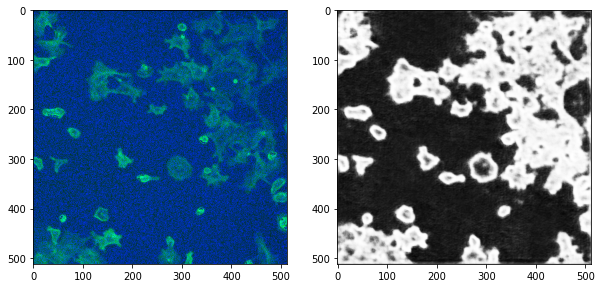

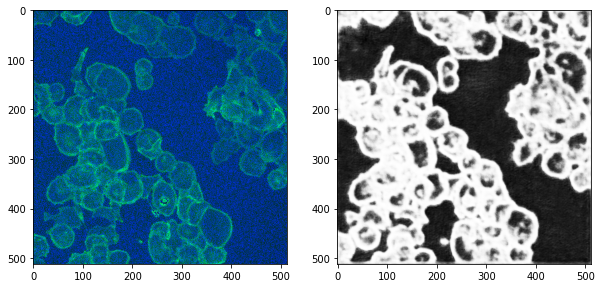

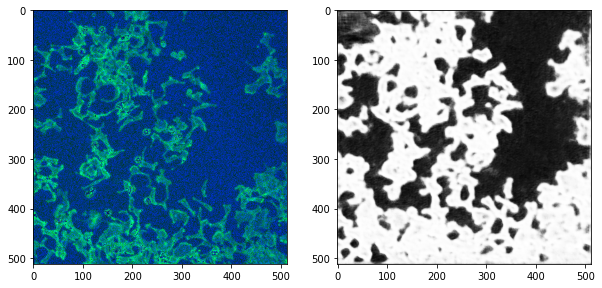

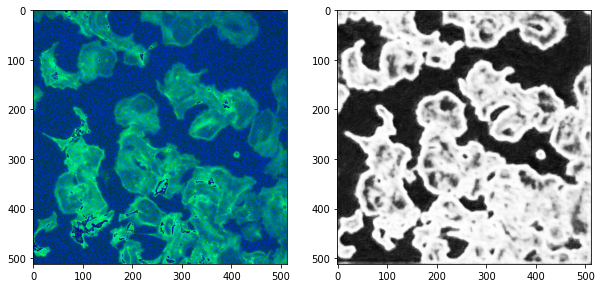

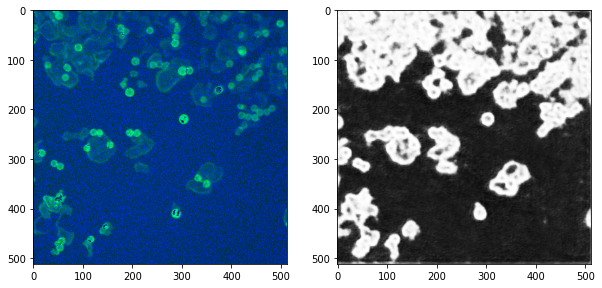

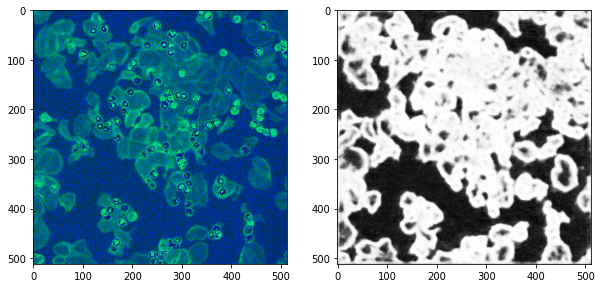

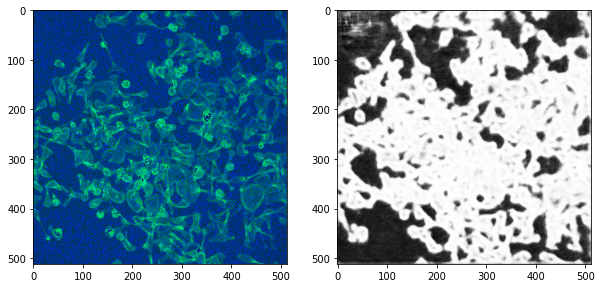

In [164]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    x_tensor = torch.Tensor(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    img = Image.open(image_path_test + test_dataset.X.id_image.loc[idx] + '.DIB.bmp')
    plt.imshow(img)
    plt.subplot(1,2,2)
    mask = pred_mask
    plt.imshow(mask, 'gray')
    plt.savefig('sample_predictions/'+ test_dataset.X.id_image.loc[idx]+'pred_mask.png')